<a href="https://colab.research.google.com/github/AhmedAloui1997/CounterfactualAugmentation/blob/main/ph_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
from tqdm.notebook import trange
from torch.distributions.multivariate_normal import MultivariateNormal as MVN
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
torch.manual_seed(0)
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the IHDP dataset

In [ ]:
names=['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1', 'x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']
#the simulation on the 6th simulation
ihdp = pd.read_csv('/content/drive/MyDrive/OrganizedSpace/PhD/Research/Causality/Datasets/IHDP1/csv/ihdp_npci_1.csv',header=0,names=names)
ihdp.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
1,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
2,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
3,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
4,0,4.762090,8.264795,4.707898,7.219442,0.467901,-0.202946,-0.733261,0.161703,0.058500,...,1,1,1,1,0,0,0,0,0,0


In [ ]:
# IHDP
features_ihdp = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']
ihdp_X = torch.tensor(ihdp[features_ihdp].values,dtype=torch.float32)
ihdp_t = torch.tensor(ihdp['treatment'].values,dtype=torch.float32)
ihdp_y = torch.tensor(ihdp['y_factual'].values,dtype=torch.float32)
ihdp_ycf = torch.tensor(ihdp['y_cfactual'].values,dtype=torch.float32)
ihdp_mu0 = torch.tensor(ihdp['mu0'].values,dtype=torch.float32)
ihdp_mu1 = torch.tensor(ihdp['mu1'].values,dtype=torch.float32)

ihdp_y1 = torch.zeros_like(ihdp_y)
ihdp_y1[ihdp_t==1] = ihdp_y[ihdp_t==1]

ihdp_y1[ihdp_t==0] = ihdp_ycf[ihdp_t==0]

ihdp_y0 = torch.zeros_like(ihdp_y)
ihdp_y0[ihdp_t==1] = ihdp_ycf[ihdp_t==1]
ihdp_y0[ihdp_t==0] = ihdp_y[ihdp_t==0]

In [ ]:
import numpy as np
import pandas as pd
import torch

# Assuming you have the ihdp DataFrame
features_ihdp = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25']
ihdp_X = torch.tensor(ihdp[features_ihdp].values,dtype=torch.float32)
ihdp_t = torch.tensor(ihdp['treatment'].values,dtype=torch.float32)
ihdp_y = torch.tensor(ihdp['y_factual'].values,dtype=torch.float32)

### The TARNet architecture

In [ ]:
class CFR(nn.Module):
  def __init__(self, input_dim, output_dim, rep_dim=25,hyp_dim=15):
    '''
    input_dim: dimension of the input features, treatment is not considered to be a feature
    output_dim: dimension of the output data, each potential outcome
    rep_dim: dimension of the representation layers, assumed to be the same
    hyp_dim: dimension of the hypothese layers for each potential outcome
    '''
    super().__init__()

    #representation layer
    encoder = [nn.Linear(input_dim,rep_dim),nn.ELU(),nn.Linear(rep_dim,rep_dim),nn.ELU(),nn.Linear(rep_dim,rep_dim),nn.ELU()]
    self.encoder = nn.Sequential(*encoder)

    #Potential outcome y0
    func0 = [nn.Linear(rep_dim,hyp_dim),nn.ELU(),nn.Linear(hyp_dim, hyp_dim),nn.ELU(),nn.Linear(hyp_dim, output_dim)]
    self.func0 = nn.Sequential(*func0)
    #potential outcome y1
    func1 = [nn.Linear(rep_dim,hyp_dim),nn.ELU(),nn.Linear(hyp_dim, hyp_dim),nn.ELU(),nn.Linear(hyp_dim, output_dim)]
    self.func1 = nn.Sequential(*func1)
    #add batch normalization

  def forward(self,X):

    # The input features (covariates) are first mapped in a hidden representation space
    # to measure the distance between Z0 and Z1

    Phi = self.encoder(X)

    # Pass the transformed features through potential outcomes predicting networks
    Y0 = self.func0(Phi)
    Y1 = self.func1(Phi)

    return Phi, Y0, Y1

In [ ]:
!pip install geomloss

In [ ]:
from geomloss import SamplesLoss

class Wassertein_Loss(nn.Module):
  def __init__(self,p=1,blur=0.05):
    super(Wassertein_Loss, self).__init__()
    self.p = p
    self.blur = blur
  def forward(self,phi1,phi0):
    samples_loss = SamplesLoss(loss="sinkhorn", p=self.p, blur=self.blur, backend="tensorized")
    imbalance_loss = samples_loss(phi1, phi0)
    return imbalance_loss
wass = Wassertein_Loss()

In [ ]:
#@title Train the
from sklearn.model_selection import train_test_split

def train_cfr(net,epochs,data,ihdp_X,ihdp_mu0,ihdp_mu1,dim,batch,lr,decay):
    # Prepare for training
    tqdm_epoch = tqdm.trange(epochs)
    optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay=decay)
    mse = nn.MSELoss()

    # Extract feature vector X, treatment indicator t, and outcome y from data
    X = data[:,:dim]
    t = data[:,dim]
    y = data[:,dim+1:dim+2]
    y0 = y[t==0]
    y1 = y[t==1]

    # Calculate weight coefficients for the loss function
    u = torch.mean(t)
    wt = 1/(2*u)
    wc = 1/(2*(1-u))

    # Split the data into training and testing datasets
    train_data, test_data, train_mu0, test_mu0, train_mu1, test_mu1 = train_test_split(data, ihdp_mu0, ihdp_mu1, test_size=0.2)

    # Create a DataLoader for the training set
    loader = DataLoader(train_data, batch_size=batch, shuffle=True)

    # Initialize list to store the performance metric
    list_perf = []

    # Hyperparameter for the loss function
    alpha = 3

    # Train for the specified number of epochs
    for _ in tqdm_epoch:
        # For each batch in the training data
        for tr in loader:
            # Extract treatment indicator, feature vector, and outcome from the current batch
            train_t = tr[:,dim]
            train_X = tr[:,0:dim]
            train_y = tr[:,dim+1:dim+2]
            train_Y0 = train_y[train_t==0]
            train_Y1 = train_y[train_t==1]

            # Forward pass through the network
            phi, y0, y1 = net(train_X)

            # Zero the gradients before the backward pass
            optimizer.zero_grad()

            # Calculate the loss and perform the backward pass
            loss = wc * mse(y0[train_t==0],train_Y0) + wt * mse(y1[train_t==1],train_Y1) + alpha * wass(phi[train_t==0],phi[train_t==1])  #+ alpha * wass(train_X[train_t==1],phi[train_t==1])
            loss.backward()

            # Update the weights
            optimizer.step()

        # Display the current total loss and losses for each outcome
        tqdm_epoch.set_description('Total Loss: {:3f} --- FL0 = {:3f}, FL1 = {:3f}'.format(loss.cpu().detach().numpy(),mse(y0[train_t==0],train_Y0).cpu().detach().numpy(),mse(y1[train_t==1],train_Y1).cpu().detach().numpy()))

        # Evaluation on test data
        test_X = test_data[:,0:dim]
        _,y0_est,y1_est = net(test_X)

        # Calculate the performance metric
        e_pehe = torch.sqrt(torch.mean((y1_est-y0_est-test_mu1+test_mu0)**2))

        # Append the performance metric to the list for tracking
        list_perf.append(e_pehe.item())

    return list_perf


In [ ]:
net = CFR(25,1)
lr =1e-3

EPOCHS = 100
batch = 100
decay = 1e-5

dim = 25
#data = torch.concatenate((ihdp_X,ihdp_t.reshape(-1,1),ihdp_y.reshape(-1,1)),axis=1)
data = torch.concatenate((ihdp_X,ihdp_t.reshape(-1,1),ihdp_y.reshape(-1,1)),axis=1)
model = train_cfr(net,EPOCHS,data,ihdp_X,ihdp_mu0,ihdp_mu1,dim,batch,lr,decay)


Total Loss: 11.571728 --- FL0 = 2.458901, FL1 = 3.216336: 100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


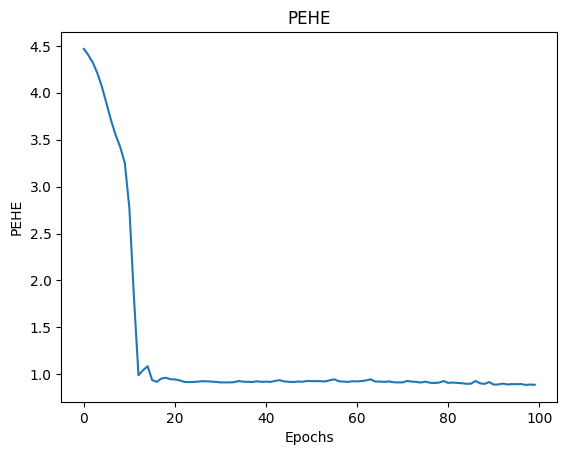

The minumu value is 0.8872361779212952


In [ ]:
plt.plot(model)
plt.xlabel('Epochs')
plt.ylabel('PEHE')
plt.title('PEHE')
plt.show()
print("The minumu value is",min(model))


## Persistent Homology And Counterfactual Regression

In [ ]:
!pip install gudhi

In [ ]:
import gudhi as gd
import numpy as np

def compute_persistence_diagram(features):
    # Construct a simplex tree from the feature set
    rips_complex = gd.RipsComplex(points=features, max_edge_length=50)

    # Construct a simplex tree from the Rips complex
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

    # Compute the persistent homology of the simplex tree
    persistence = simplex_tree.persistence()
    #print(persistence.shape)
    # Convert the persistent homology to a format suitable for computing distances
    persistence_diagram = np.array([x[1] for x in persistence if x[0] == 1])
    #print(persistent_diagram.shape)
    return persistence_diagram


In [ ]:
#define a distance between the persistent homologies
from geomloss import SamplesLoss
import torch.nn.functional as F

class SlicedWassersteinDistance(nn.Module):
    def __init__(self, p=1, blur=.05):
        super().__init__()
        self.p = p
        self.blur = blur
        self.loss_fn = SamplesLoss("sinkhorn", p=self.p, blur=self.blur)

    def forward(self, phi1, phi0):
        # Convert the features into persistence diagrams
        # This step requires a library that supports differentiable computation of persistent homology
        pd1 = compute_persistence_diagram(phi1)
        pd0 = compute_persistence_diagram(phi0)

        # Check if pd1 or pd0 is empty
        if pd1.size == 0:
            pd1 = np.array([[0, 0]])  # dummy point
        if pd0.size == 0:
            pd0 = np.array([[0, 0]])  # dummy point

        # Convert the numpy arrays to torch tensors
        pd1 = torch.tensor(pd1, device=phi1.device)
        pd0 = torch.tensor(pd0, device=phi0.device)

        # print the persistent homolgies data shapes
        print()

        pd1 = pd1.float()
        pd0 = pd0.float()

        # Compute the sliced wasserstein distance between the persistence diagrams
        swd = self.loss_fn(pd1, pd0)
        return swd


In [ ]:
topo_loss = SlicedWassersteinDistance()

In [ ]:
from sklearn.model_selection import train_test_split

def train_homology_cfr(net,epochs,data,ihdp_X,ihdp_mu0,ihdp_mu1,dim,batch,lr,decay):
    tqdm_epoch = tqdm.trange(epochs)
    optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=decay)
    mse = nn.MSELoss()

    # Extract feature vector X, treatment indicator t and outcome y from data
    X = data[:,:dim]
    t = data[:,dim]
    y = data[:,dim+1:dim+2]
    y0 = y[t==0]
    y1 = y[t==1]

    # Calculate weight coefficients for the loss function
    u = torch.mean(t)
    wt = 1/(2*u)
    wc = 1/(2*(1-u))

    # Split the data into training and testing datasets
    train_data, test_data, train_mu0, test_mu0, train_mu1, test_mu1 = train_test_split(data, ihdp_mu0, ihdp_mu1, test_size=0.2)

    # Initialize data loader for the training set
    loader = DataLoader(train_data, batch_size=batch, shuffle=True)

    list_perf = []
    alpha = 3
    for _ in tqdm_epoch:
        # For each batch in training data
        for tr in loader:
            # Extract treatment indicator, feature vector and outcome from current batch
            train_t = tr[:,dim]
            train_X = tr[:,0:dim]
            train_y = tr[:,dim+1:dim+2]
            train_Y0 = train_y[train_t==0]
            train_Y1 = train_y[train_t==1]

            # Forward pass through the network
            phi, y0, y1 = net(train_X)

            # Zero the gradients before backward pass
            optimizer.zero_grad()

            # Calculate the loss and perform backward pass
            loss = wc * mse(y0[train_t==0],train_Y0) + wt * mse(y1[train_t==1],train_Y1) + alpha * topo_loss(phi[train_t==0],phi[train_t==1]) + alpha * wass(phi[train_t==0],phi[train_t==1]) #+ + alpha * topo_loss(train_X[train_t==1],phi[train_t==1])
            loss.backward()

            # Update the weights
            optimizer.step()

        tqdm_epoch.set_description('Total Loss: {:3f} --- FL0 = {:3f}, FL1 = {:3f}'.format(loss.cpu().detach().numpy(),mse(y0[train_t==0],train_Y0).cpu().detach().numpy(),mse(y1[train_t==1],train_Y1).cpu().detach().numpy()))

        # Evaluation on test data
        test_X = test_data[:,0:dim]
        _,y0_est,y1_est = net(test_X)

        # Calculate the performance metric
        e_pehe = torch.sqrt(torch.mean((y1_est-y0_est-test_mu1+test_mu0)**2))

        # Append the performance metric to the list for tracking
        list_perf.append(e_pehe.item())

    return list_perf


In [ ]:
net2 = CFR(25,1)
lr =1e-3

EPOCHS = 100
batch = 100
decay = 1e-5

dim = 25
#data = torch.concatenate((ihdp_X,ihdp_t.reshape(-1,1),ihdp_y.reshape(-1,1)),axis=1)
data = torch.concatenate((ihdp_X,ihdp_t.reshape(-1,1),ihdp_y.reshape(-1,1)),axis=1)
results_homology = train_cfr(net2,EPOCHS,data,ihdp_X,ihdp_mu0,ihdp_mu1,dim,batch,lr,decay)

Total Loss: 7.370038 --- FL0 = 2.479624, FL1 = 2.021045: 100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


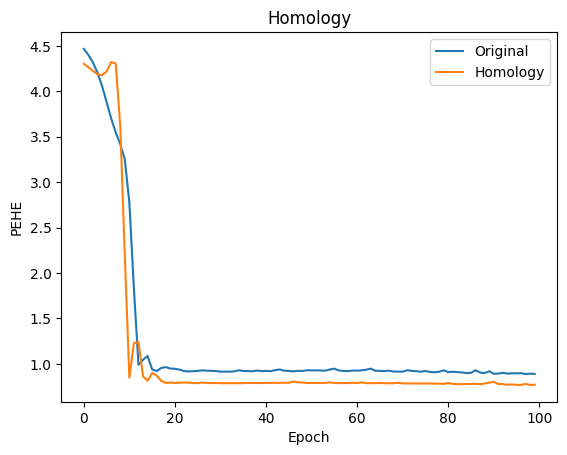

The minumum value is 0.8872361779212952
The minumum value (Peristent Homology) is 0.7677367925643921


In [ ]:
plt.plot(model)
plt.plot(results_homology)
plt.legend(['Original','Homology'])
plt.xlabel('Epoch')
plt.ylabel('PEHE')
plt.title('Homology')
plt.show()

print("The minumum value is",min(model))
print("The minumum value (Peristent Homology) is",min(results_homology))


### Adding noise to the data experiment

In [ ]:
ihdp_X_ = ihdp_X + torch.randn(ihdp_X.shape)
ihdp_t = ihdp_t #no noise for treatment :)
ihdp_y = ihdp_y #+ torch.randn(ihdp_y.shape)

In [ ]:
#train with no persistent homology
net_noisy = CFR(25,1,64)
net_homology_noisy = CFR(25,1,64)


lr =1e-2

EPOCHS = 100
batch = 200
decay = 1e-5

dim = 25



#data = torch.concatenate((ihdp_X,ihdp_t.reshape(-1,1),ihdp_y.reshape(-1,1)),axis=1)
data = torch.concatenate((ihdp_X_,ihdp_t.reshape(-1,1),ihdp_y.reshape(-1,1)),axis=1)
data = data.float()
ihdp_X_ = ihdp_X_.float()
ihdp_t = ihdp_t.float()
ihdp_y = ihdp_y.float()

results_original_noisy = train_cfr(net_noisy,EPOCHS,data,ihdp_X,ihdp_mu0,ihdp_mu1,dim,batch,lr,decay)
#data = torch.tensor(data)
results_homology_noisy = train_homology_cfr(net_homology_noisy,EPOCHS,data,ihdp_X,ihdp_mu0,ihdp_mu1,dim,batch,lr,decay)

Total Loss: 2.679522 --- FL0 = 3.506844, FL1 = 0.069272: 100%|██████████| 100/100 [00:07<00:00, 12.63it/s]
  0%|          | 0/100 [00:00<?, ?it/s]

Total Loss: 122.212341 --- FL0 = 8.017954, FL1 = 42.616241:   1%|          | 1/100 [00:02<04:06,  2.49s/it]

Total Loss: 51.916252 --- FL0 = 3.725485, FL1 = 17.009808:   2%|▏         | 2/100 [00:04<03:21,  2.06s/it]

Total Loss: 33.305035 --- FL0 = 5.741786, FL1 = 9.241343:   3%|▎         | 3/100 [00:05<03:05,  1.91s/it]

Total Loss: 13.585103 --- FL0 = 3.566662, FL1 = 2.951984:   4%|▍         | 4/100 [00:07<02:56,  1.84s/it]

Total Loss: 24.405802 --- FL0 = 4.455036, FL1 = 7.062498:   5%|▌         | 5/100 [00:09<02:45,  1.74s/it]

Total Loss: 13.926773 --- FL0 = 3.020854, FL1 = 3.234263:   6%|▌         | 6/100 [00:11<02:50,  1.81s/it]

Total Loss: 14.847641 --- FL0 = 3.760802, FL1 = 3.484534:   7%|▋         | 7/100 [00:14<03:18,  2.13s/it]

Total Loss: 10.812622 --- FL0 = 3.218497, FL1 = 2.321892:   8%|▊         | 8/100 [00:16<03:23,  2.22s/it]

Total Loss: 9.390488 --- FL0 = 4.393421, FL1 = 1.634337:   9%|▉         | 9/100 [00:18<03:06,  2.05s/it]

Total Loss: 11.270809 --- FL0 = 3.299242, FL1 = 2.608958:  10%|█         | 10/100 [00:19<02:58,  1.98s/it]

Total Loss: 8.012202 --- FL0 = 3.947896, FL1 = 1.468545:  11%|█         | 11/100 [00:21<02:49,  1.91s/it]

Total Loss: 11.321827 --- FL0 = 3.945351, FL1 = 2.534499:  12%|█▏        | 12/100 [00:23<02:39,  1.82s/it]

Total Loss: 8.705635 --- FL0 = 2.870665, FL1 = 2.153651:  13%|█▎        | 13/100 [00:24<02:31,  1.74s/it]

Total Loss: 10.671522 --- FL0 = 2.947492, FL1 = 2.805515:  14%|█▍        | 14/100 [00:27<02:50,  1.98s/it]

Total Loss: 10.103182 --- FL0 = 3.826071, FL1 = 2.490098:  15%|█▌        | 15/100 [00:29<03:02,  2.15s/it]

Total Loss: 10.078377 --- FL0 = 3.948760, FL1 = 2.534524:  16%|█▌        | 16/100 [00:31<02:50,  2.02s/it]

Total Loss: 11.228498 --- FL0 = 4.121355, FL1 = 2.952643:  17%|█▋        | 17/100 [00:33<02:39,  1.92s/it]

Total Loss: 9.638999 --- FL0 = 3.352781, FL1 = 2.415942:  18%|█▊        | 18/100 [00:35<02:32,  1.86s/it]

Total Loss: 12.295996 --- FL0 = 3.207633, FL1 = 3.354146:  19%|█▉        | 19/100 [00:36<02:26,  1.81s/it]

Total Loss: 9.998388 --- FL0 = 2.756454, FL1 = 2.678095:  20%|██        | 20/100 [00:38<02:21,  1.77s/it]

Total Loss: 9.816175 --- FL0 = 4.604921, FL1 = 2.035614:  21%|██        | 21/100 [00:41<02:39,  2.02s/it]

Total Loss: 9.285748 --- FL0 = 3.437876, FL1 = 2.332114:  22%|██▏       | 22/100 [00:43<02:50,  2.18s/it]

Total Loss: 8.631116 --- FL0 = 3.445666, FL1 = 1.955413:  23%|██▎       | 23/100 [00:45<02:37,  2.04s/it]

Total Loss: 7.401380 --- FL0 = 2.840468, FL1 = 1.914864:  24%|██▍       | 24/100 [00:47<02:29,  1.97s/it]

Total Loss: 7.923033 --- FL0 = 2.845787, FL1 = 2.135108:  25%|██▌       | 25/100 [00:48<02:25,  1.94s/it]

Total Loss: 12.577482 --- FL0 = 4.139189, FL1 = 3.261920:  26%|██▌       | 26/100 [00:50<02:19,  1.89s/it]

Total Loss: 9.924225 --- FL0 = 3.085718, FL1 = 2.627712:  27%|██▋       | 27/100 [00:52<02:15,  1.86s/it]

Total Loss: 9.343117 --- FL0 = 3.821948, FL1 = 2.056749:  28%|██▊       | 28/100 [00:54<02:20,  1.95s/it]

Total Loss: 8.582191 --- FL0 = 3.351205, FL1 = 2.070693:  29%|██▉       | 29/100 [00:57<02:27,  2.07s/it]

Total Loss: 8.823084 --- FL0 = 3.531163, FL1 = 1.868960:  30%|███       | 30/100 [00:58<02:13,  1.91s/it]

Total Loss: 8.501854 --- FL0 = 3.409345, FL1 = 1.809944:  31%|███       | 31/100 [01:00<02:10,  1.89s/it]

/usr/local/lib/python3.10/dist-packages/geomloss/sinkhorn_divergence.py:147: RuntimeWarning: divide by zero encountered in log
  p * np.log(diameter), p * np.log(blur), p * np.log(scaling)
Total Loss: 8.501854 --- FL0 = 3.409345, FL1 = 1.809944:  31%|███       | 31/100 [01:01<02:16,  1.98s/it]

ValueError: ignored

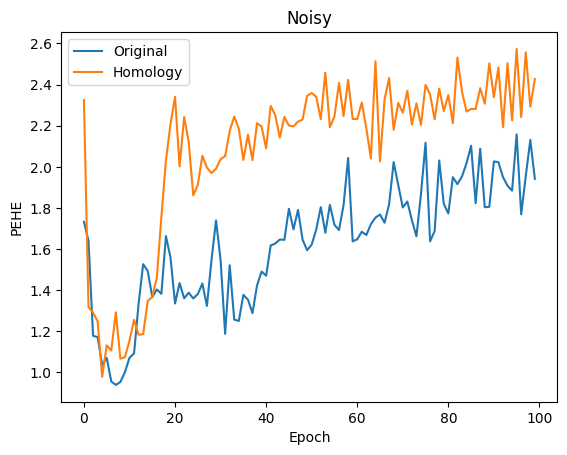

The minumum value is 0.9390599727630615
The minumum value (Peristent Homology) is 0.978537917137146


In [ ]:
plt.plot(results_original_noisy)
plt.plot(results_homology_noisy)
plt.legend(['Original','Homology'])
plt.xlabel('Epoch')
plt.ylabel('PEHE')
plt.title('Noisy')
plt.show()

print("The minumum value is",min(results_original_noisy))
print("The minumum value (Peristent Homology) is",min(results_homology_noisy))

